In [1]:
import numpy as np
from math import pi
from matplotlib import pyplot
from scipy.linalg import block_diag
from ipywidgets import interact

In [4]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3
m0=9.1e-31 # kg
m=m0/10

B=10 # Tesla
hwc=hbar*(elec*B/m)
lB=np.sqrt(hbar/(elec*B))
mu_sc=20*hwc #1e2*meV
D_sc=2*hwc #10*meV
nu=1
mu_n=nu*hwc #10*meV

ky_sw=np.linspace(-1,1,140)*7.5/lB


# Lx=100e-9
Lx=12*lB
Nx=100
kx=2*pi*np.arange(Nx)/(2*Lx)-pi*Nx/(2*Lx)
[k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx)-pi*Nx/(2*Lx)

Hx=np.diag(hbar**2 * kx**2/(2*m))

def y2(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c= (-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx)
        c[ ~ np.isfinite( c )] = Lx**2 /6.0
    return c

def y1(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = (-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx)
        c[ ~ np.isfinite( c )] = Lx/4.0
    return c

def y0(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = -1j*(-1+np.exp(1j*k*Lx) )/(k*2*Lx)
        c[ ~ np.isfinite( c )] = 0.5
    return c

def y0s(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = 1j*(-1+np.exp(-1j*k*Lx) )/(k*2*Lx)
        c[ ~ np.isfinite( c )] = 0.5
    return c


HeB2= ((elec*B)**2 *y2(k1-k2))/ (2*m)
HeB2T= ((elec*B)**2 *y2(k2-k1))/ (2*m)
Hef= -( mu_n*y0(k1-k2) + mu_sc*y0(k2-k1) )
HefT= -( mu_n*y0(k2-k1) + mu_sc*y0(k1-k2) )
Hd= D_sc*y0(k2-k1) 
# Hd= D_sc*np.eye(Nx)

sigma1=np.array([[0,1],[1,0]])
sigma2=np.array([[0,-1j],[1j,0]])
sigma3=np.array([[1,0],[0,-1]])

En=np.zeros((2*Nx,len(ky_sw)))
Vn=np.zeros((2*Nx,2*Nx,len(ky_sw)), dtype=np.complex64)
for i_y in range(len(ky_sw)):
    ky=ky_sw[i_y]
    Hy=(hbar**2 * ky**2/(2*m))*np.eye(Nx)
    HeB1=-hbar *ky* ( elec*B*y1(k1-k2))/m
    HeB1T=hbar *ky* ( elec*B*y1(k2-k1))/m
    H1=Hx+Hy+HeB2+HeB1+Hef
    H1T=Hx+Hy+(HeB2T+HeB1T+HefT).conj()
    Hd_mat=np.kron(np.array([[0.,1.0],[0.,0.]]),Hd)
    H_t=block_diag(H1,-H1T)+Hd_mat+np.transpose(Hd_mat).conj()
    En[:,i_y], Vn[:,:,i_y] =np.linalg.eigh(H_t)
    
print("Done!")

Done!


In [3]:
def wf_real_space(ev,k,x,Lx):
    Nx=len(k)
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x,[len(x),1])
    return np.dot(np.exp(1j*kt*(xt)),ev[:Nx,:])/np.sqrt(2*Lx)*np.sqrt(x[1]-x[0]),\
            np.dot(np.exp(1j*kt*(xt)),ev[Nx:2*Nx,:])/np.sqrt(2*Lx)*np.sqrt(x[1]-x[0])

def plot_wf(i_band=Nx,iwf=int(3*len(ky_sw)/4)):
# iwf=0
    pyplot.figure()
    pyplot.subplot(2,1,1)
    pyplot.plot(ky_sw*lB,En.T/hwc,'b')
    pyplot.plot(ky_sw[iwf]*lB,En[i_band,iwf]/hwc,'ro')
    pyplot.ylabel("Energy(meV)")
    pyplot.xlabel("X(l)")
    pyplot.ylim(-3,3)
    # pyplot.xlim(-7.5,7.5)
    pyplot.grid()
#     pyplot.show()

    x0=np.linspace(-1,1,500)*10*lB
    wf1_p,wf1_h=wf_real_space(np.reshape(Vn[:,i_band,:],[2*Nx,len(ky_sw)]),kx,x0,Lx)
#     pyplot.figure()
    pyplot.subplot(2,1,2)
    pyplot.plot(x0/lB,np.abs(wf1_p[:,iwf])**2)
    pyplot.plot(x0/lB,np.abs(wf1_h[:,iwf])**2)
    pyplot.title('ky=%.2f' % (ky_sw[iwf]*lB) )
    pyplot.show()

In [4]:
interact(plot_wf,iwf=(0,len(ky_sw)-1,1), i_band=range(Nx-nu,Nx+nu));
#, continuous_update=False);

interactive(children=(Dropdown(description='i_band', index=1, options=(99, 100), value=100), IntSlider(value=1…

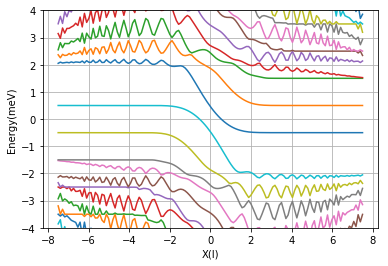

In [5]:
pyplot.figure()
# pyplot.plot(ky_sw/1e9,En.T/meV)
pyplot.plot(ky_sw*lB,En.T/hwc)
pyplot.ylabel("Energy(meV)")
# pyplot.xlabel("ky(1/nm)")
pyplot.xlabel("X(l)")
pyplot.ylim(-4,4)
# pyplot.xlim(-7.5,7.5)
pyplot.grid()
pyplot.show()

In [301]:
a=np.reshape(range(4),[2,2])
b=np.reshape(range(4,8),[2,2])
Hd=sigma2+1j*sigma3
x=block_diag(a,b)+np.kron(np.array([[0.,1.0],[0.,0.]]),Hd)+np.kron(np.array([[0.,0.],[1.0,0.]]),np.transpose(Hd).conj())
print(x)

[[0.+0.j 1.+0.j 0.+1.j 0.-1.j]
 [2.+0.j 3.+0.j 0.+1.j 0.-1.j]
 [0.-1.j 0.-1.j 4.+0.j 5.+0.j]
 [0.+1.j 0.+1.j 6.+0.j 7.+0.j]]


In [348]:
print(D_sc/meV)

0.0
